In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from  tensorflow.keras.layers import Dense, Input

In [2]:
!pip install -U scikit-learn

In [3]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('sp500sub.csv', index_col = 'Date', parse_dates = True)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [6]:
df['Name'].value_counts()

CAH     2265
KIM     2264
NEM     2264
SLG     2264
RSG     2264
        ... 
ALLE    1287
HLT     1270
SYF     1112
SCG      871
IR       411
Name: Name, Length: 104, dtype: int64

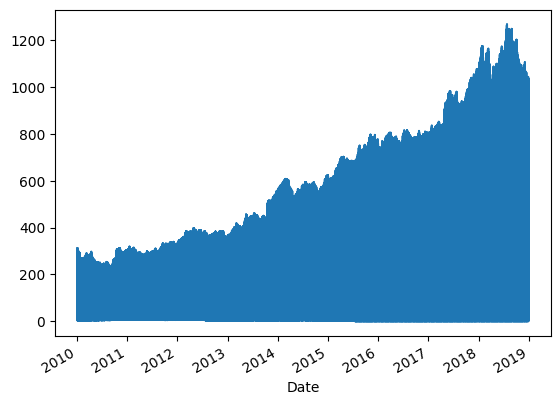

In [7]:
df['Close'].plot();

In [8]:
df_sb = df[df['Name'] == 'SBUX'][['Close']].copy()

In [9]:
df_sb

,Close
Date,
2010-01-04,11.525000
2010-01-05,11.795000
2010-01-06,11.710000
2010-01-07,11.680000
2010-01-08,11.640000
...,...
2018-12-21,61.389999
2018-12-24,60.560001
2018-12-26,63.080002


In [10]:
df_sb['LogClose'] = np.log(df_sb['Close'])

<Axes: xlabel='Date'>

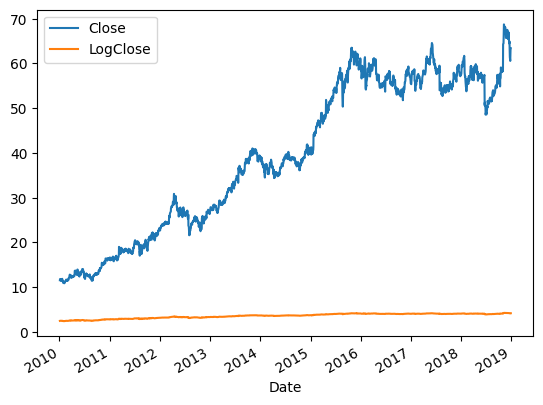

In [11]:
df_sb.plot()

In [12]:
df_sb['DiffClose'] = df_sb['LogClose'].diff()

In [13]:
Ntest = 21
train = df_sb.iloc[:-Ntest]
test = df_sb.iloc[-Ntest:]

In [14]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[['DiffClose']])
scaled_test = scaler.transform(test[['DiffClose']])

In [15]:
train_idx = df_sb.index <= train.index[-1]
test_idx = df_sb.index > train.index[-1]

In [16]:
df_sb.loc[train_idx, 'ScaledLogReturn'] = scaled_train.flatten()
df_sb.loc[test_idx, 'ScaledLogTestReturn'] = scaled_test.flatten()

In [17]:
series = df_sb['ScaledLogReturn'].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)



X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)


print(f'X.shape : {X.shape}, Y.shape : {Y.shape}')

X.shape : (2231, 10), Y.shape : (2231,)


In [18]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [19]:
i = Input(shape = (T,))
x = Dense(32, activation = 'relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [20]:
model.compile(
    loss = 'mse',
    optimizer = 'Adam',
)

In [21]:
results = model.fit(
    Xtrain,
    Ytrain,
    epochs = 200,
    validation_data = (Xtest, Ytest)
)

Epoch 1/200
70/70 [==============================] - 2s 5ms/step - loss: 1.1819 - val_loss: 2.4127
Epoch 2/200
70/70 [==============================] - 0s 3ms/step - loss: 1.0420 - val_loss: 2.5715
Epoch 3/200
70/70 [==============================] - 0s 3ms/step - loss: 1.0074 - val_loss: 2.5674
Epoch 4/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9940 - val_loss: 2.5803
Epoch 5/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9831 - val_loss: 2.5608
Epoch 6/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9756 - val_loss: 2.5807
Epoch 7/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9692 - val_loss: 2.5755
Epoch 8/200
70/70 [==============================] - 0s 4ms/step - loss: 0.9623 - val_loss: 2.4893
Epoch 9/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9570 - val_loss: 2.5272
Epoch 10/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9541 - val_loss: 2.3969
Epoch 11/

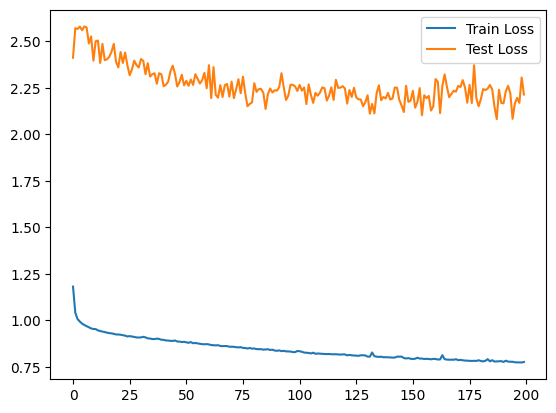

In [22]:
plt.plot(results.history['loss'], label = 'Train Loss')
plt.plot(results.history['val_loss'], label = 'Test Loss')
plt.legend();

In [23]:
train_idx[:T+1] = False